In [ ]:
# Install library yang dibutuhkan
!pip install kaggle
!pip install tensorflow
!pip install xgboost
!pip install scikit-learn

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from xgboost import XGBClassifier

# Upload API Kaggle JSON
from google.colab import files
files.upload()  # Upload file kaggle.json Anda

# Konfigurasi Kaggle
os.makedirs('/root/.kaggle', exist_ok=True)
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

# Download dataset
!kaggle datasets download -d warcoder/nutrient-deficient-banana-plant-leaves
!unzip nutrient-deficient-banana-plant-leaves.zip -d banana_dataset

Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: banana_dataset/Nutrient Deficient Banana Plant Leaves/Augmented Images of Nutrient Deficient Banana leaves/potassium/k522.jpg  
  inflating: banana_dataset/Nutrient Deficient Banana Plant Leaves/Augmented Images of Nutrient Deficient Banana leaves/potassium/k523.jpg  
  inflating: banana_dataset/Nutrient Deficient Banana Plant Leaves/Augmented Images of Nutrient Deficient Banana leaves/potassium/k524.jpg  
  inflating: banana_dataset/Nutrient Deficient Banana Plant Leaves/Augmented Images of Nutrient Deficient Banana leaves/potassium/k525.jpg  
  inflating: banana_dataset/Nutrient Deficient Banana Plant Leaves/Augmented Images of Nutrient Deficient Banana leaves/potassium/k526.jpg  
  inflating: banana_dataset/Nutrient Deficient Banana Plant Leaves/Augmented Images of Nutrient Deficient Banana leaves/potassium/k527.jpg  
  inflating: banana_dataset/Nutrient Deficient Banana Plant Leaves/Augmented Images of Nutrient

In [ ]:
# Set ukuran gambar dan batch size
IMG_SIZE = (128, 128)  # Ukuran gambar diubah menjadi 128x128
BATCH_SIZE = 32

# Path ke root direktori dataset
DATASET_DIR = '/content/banana_dataset/Nutrient Deficient Banana Plant Leaves/Nutrient Deficient RAW Images of Banana Leaves'

# Data Augmentation & Preprocessing
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    horizontal_flip=True,
    rotation_range=20,
    zoom_range=0.2
)

# Load Training Data
train_data = datagen.flow_from_directory(
    DATASET_DIR,                   # Path ke dataset yang benar
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

# Load Validation Data
val_data = datagen.flow_from_directory(
    DATASET_DIR,                   # Path ke dataset yang benar
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

Found 2481 images belonging to 9 classes.
Found 619 images belonging to 9 classes.


In [ ]:
# Visualisasi 3 citra per label/kelas
def visualize_samples(data_generator):
    class_names = list(data_generator.class_indices.keys())
    num_classes = len(class_names)
    plt.figure(figsize=(15, 10))
    for class_idx, class_name in enumerate(class_names):
        sample_count = 0
        for inputs_batch, labels_batch in data_generator:
            for i in range(inputs_batch.shape[0]):
                if sample_count >= 3:
                    break
                if np.argmax(labels_batch[i]) == class_idx:
                    plt.subplot(num_classes, 3, class_idx * 3 + sample_count + 1)
                    plt.imshow(inputs_batch[i])
                    plt.title(class_name)
                    plt.axis('off')
                    sample_count += 1
            if sample_count >= 3:
                break
    plt.tight_layout()
    plt.show()

Visualisasi 3 citra per label/kelas:


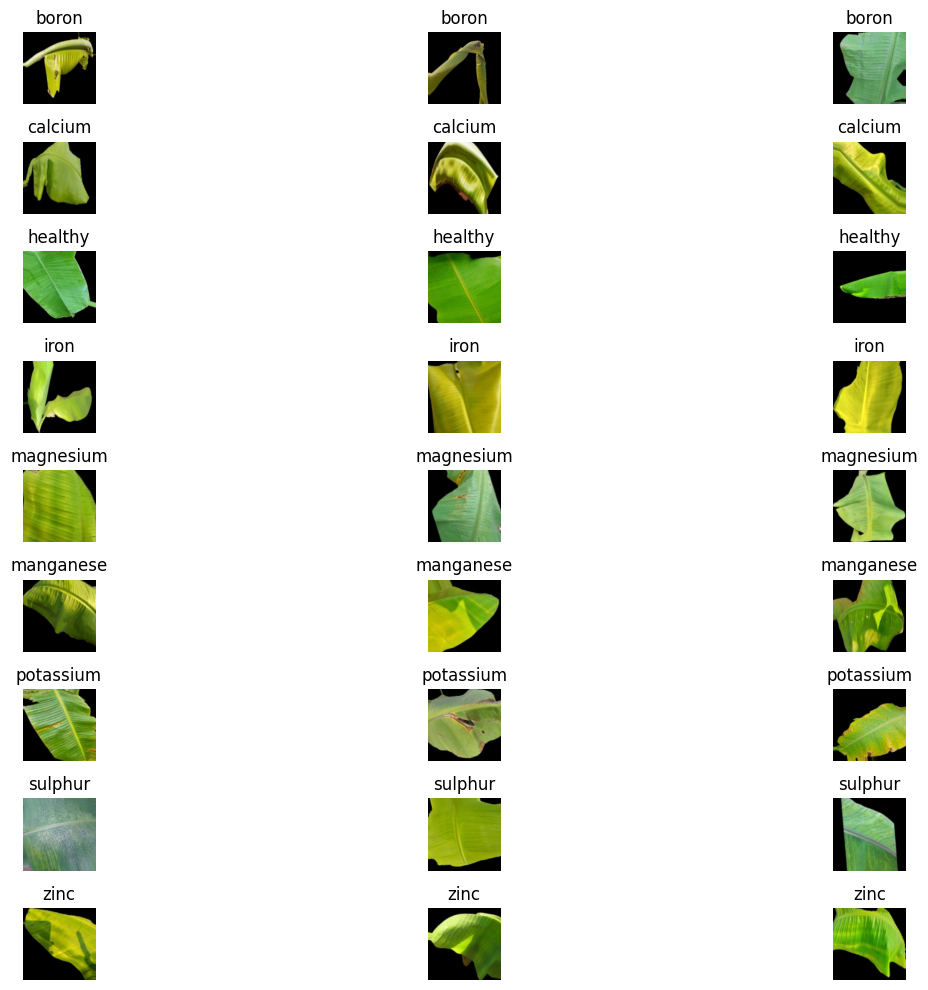

In [ ]:
# Visualisasi 3 citra per label/kelas
def visualize_samples(data_generator):
    class_names = list(data_generator.class_indices.keys())
    num_classes = len(class_names)
    plt.figure(figsize=(15, 10))
    for class_idx, class_name in enumerate(class_names):
        sample_count = 0
        for inputs_batch, labels_batch in data_generator:
            for i in range(inputs_batch.shape[0]):
                if sample_count >= 3:
                    break
                if np.argmax(labels_batch[i]) == class_idx:
                    plt.subplot(num_classes, 3, class_idx * 3 + sample_count + 1)
                    plt.imshow(inputs_batch[i])
                    plt.title(class_name)
                    plt.axis('off')
                    sample_count += 1
            if sample_count >= 3:
                break
    plt.tight_layout()
    plt.show()

# Visualisasi 3 citra per label/kelas sebelum augmentasi
print("Visualisasi 3 citra per label/kelas:")
visualize_samples(train_data)

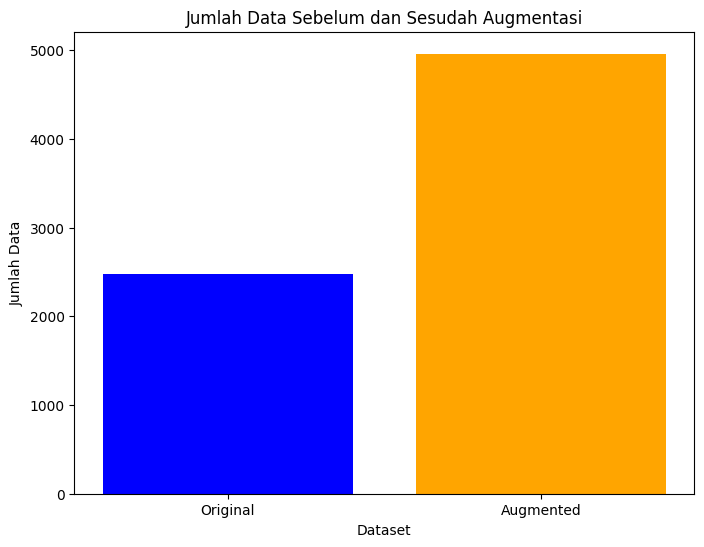

In [ ]:
# Hitung jumlah data setelah augmentasi
def count_augmented_data(data_generator):
    return data_generator.n

num_original = train_data.n
num_augmented = train_data.n * 2  # Karena augmentasi data hanya berlaku saat training

# Visualisasi jumlah data sebelum dan sesudah augmentasi
plt.figure(figsize=(8, 6))
plt.bar(['Original', 'Augmented'], [num_original, num_augmented], color=['blue', 'orange'])
plt.title('Jumlah Data Sebelum dan Sesudah Augmentasi')
plt.xlabel('Dataset')
plt.ylabel('Jumlah Data')
plt.show()


In [ ]:
# Load pre-trained DenseNet121 tanpa layer top (fully connected)
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Ekstraksi Fitur
def extract_features(data_generator, model):
    features = []
    labels = []
    for inputs_batch, labels_batch in data_generator:
        features_batch = model.predict(inputs_batch)
        features.append(features_batch)
        labels.append(labels_batch)
        if len(features) * BATCH_SIZE >= data_generator.n:  # Membatasi iterasi sesuai jumlah data
            break
    return np.vstack(features), np.vstack(labels)

# Ekstrak fitur untuk training dan testing
X_train, y_train = extract_features(train_data, base_model)
X_val, y_val = extract_features(val_data, base_model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

In [ ]:
# Reshape fitur menjadi vektor datar untuk XGBoost
X_train = X_train.reshape((X_train.shape[0], -1))
X_val = X_val.reshape((X_val.shape[0], -1))

# Inisialisasi dan melatih model XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, np.argmax(y_train, axis=1))

# Prediksi
y_pred = xgb_model.predict(X_val)
y_true = np.argmax(y_val, axis=1)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:09:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
# Evaluasi akurasi
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))

# Laporan Evaluasi
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))